In [1]:
import pandas as pd
import requests
# from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import urllib.parse
import re
import numpy as np
import seaborn as sns
import ast
from wordcloud import WordCloud, STOPWORDS
import sklearn
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.decomposition import PCA
import ast

/Users/jiazhengli/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/jiazhengli/.vscode/extensions/ms-python.python-2020.8.109390/pythonFiles/pyvsc-run-isolated.py", line 26, in <module>
    runpy.run_module(module, run_name="__main__", alter_sys=True)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
df = pd.read_parquet('/Users/jiazhengli/Desktop/project_root/clinical_trials_interventional.parquet')
print(df.shape)
df.head()

# df = pd.read_parquet('/Users/jiazhengli/Desktop/project_root/clinical_trials_interventional.parquet', engine='pyarrow', columns=None).head(10000)
# print(df.shape)
# df.head()

(399399, 156)


,hasResults,protocolSection.identificationModule.nctId,protocolSection.identificationModule.orgStudyIdInfo.id,protocolSection.identificationModule.organization.fullName,protocolSection.identificationModule.organization.class,protocolSection.identificationModule.briefTitle,protocolSection.identificationModule.officialTitle,protocolSection.statusModule.statusVerifiedDate,protocolSection.statusModule.overallStatus,protocolSection.statusModule.expandedAccessInfo.hasExpandedAccess,...,protocolSection.oversightModule.isUnapprovedDevice,protocolSection.statusModule.delayedPosting,resultsSection.moreInfoModule.pointOfContact.phoneExt,protocolSection.designModule.nPtrsToThisExpAccNctId,protocolSection.designModule.expandedAccessTypes.individual,protocolSection.oversightModule.fdaaa801Violation,annotationSection.annotationModule.violationAnnotation.violationEvents,protocolSection.designModule.expandedAccessTypes.intermediate,protocolSection.designModule.expandedAccessTypes.treatment,protocolSection.oversightModule.isPpsd
0,False,NCT05353218,2021/923,Istanbul University,OTHER,Ultrasound-Guided Intermediate Versus Deep Cer...,Efficacy of Ultrasound-Guided Intermediate Ver...,2023-04,COMPLETED,False,...,None,None,None,NaN,None,None,None,None,None,None
1,False,NCT05713162,PIC-04-17,Fundació Sant Joan de Déu,OTHER,Evaluation of the Effect of a Social Skills Pr...,Evaluation of the Effectiveness of a Social Sk...,2022-03,COMPLETED,False,...,None,None,None,NaN,None,None,None,None,None,None
2,False,NCT05143775,KY 2020-099-01,Beijing Neurosurgical Institute,OTHER,Strategic Intervention on Preserving Language ...,Strategic Intervention on Preserving Language ...,2021-12,UNKNOWN,False,...,None,None,None,NaN,None,None,None,None,None,None
3,False,NCT05988710,222204,Vanderbilt University Medical Center,OTHER,Low-dose Buccal Buprenorphine: Relative Abuse ...,Low-dose Buccal Buprenorphine: Relative Abuse ...,2024-12,RECRUITING,False,...,None,None,None,NaN,None,None,None,None,None,None
4,False,NCT01707277,EMI,Fundación para la Investigación del Hospital C...,OTHER,The Effects of Inspiratory Muscle Training in ...,The Effects of Inspiratory Muscle Training in ...,2016-02,COMPLETED,False,...,None,None,None,NaN,None,None,None,None,None,None


In [3]:
df['protocolSection.statusModule.overallStatus'].value_counts()

protocolSection.statusModule.overallStatus
COMPLETED                  223519
UNKNOWN                     52101
RECRUITING                  48029
TERMINATED                  26359
NOT_YET_RECRUITING          17077
ACTIVE_NOT_RECRUITING       16067
WITHDRAWN                   12236
ENROLLING_BY_INVITATION      2677
SUSPENDED                    1334
Name: count, dtype: int64

In [12]:
selected_statuses = ["COMPLETED", "TERMINATED", "SUSPENDED", "WITHDRAWN"]

df = df[df['protocolSection.statusModule.overallStatus'].isin(selected_statuses)].reset_index(drop=True)
# df.shape

In [13]:
df.columns = df.columns.str.split('.', n=1).str[1].str.replace('.', '_', regex=False)

In [5]:
columns_to_keep = ['identificationModule_nctId', 'statusModule_overallStatus', 'designModule_phases', 'identificationModule_organization_class', 'oversightModule_oversightHasDmc', 'oversightModule_isFdaRegulatedDrug', 'oversightModule_isFdaRegulatedDevice',
'designModule_designInfo_allocation', 'designModule_designInfo_interventionModel', 'designModule_designInfo_primaryPurpose', 'designModule_designInfo_maskingInfo_masking', 'eligibilityModule_healthyVolunteers', 'eligibilityModule_sex', 'moreInfoModule_certainAgreement_piSponsorEmployee',
'moreInfoModule_certainAgreement_restrictiveAgreement', 'statusModule_completionDateStruct_date',
'statusModule_startDateStruct_date', 'eligibilityModule_eligibilityCriteria', 'contactsLocationsModule_locations',
'conditionBrowseModule_ancestors', 'sponsorCollaboratorsModule_collaborators', 'interventionBrowseModule_meshes',
'descriptionModule_briefSummary', 'descriptionModule_detailedDescription'
]

df = df[columns_to_keep]
print(df.shape)
df.head()

(263448, 24)


,identificationModule_nctId,statusModule_overallStatus,designModule_phases,identificationModule_organization_class,oversightModule_oversightHasDmc,oversightModule_isFdaRegulatedDrug,oversightModule_isFdaRegulatedDevice,designModule_designInfo_allocation,designModule_designInfo_interventionModel,designModule_designInfo_primaryPurpose,...,moreInfoModule_certainAgreement_restrictiveAgreement,statusModule_completionDateStruct_date,statusModule_startDateStruct_date,eligibilityModule_eligibilityCriteria,contactsLocationsModule_locations,conditionBrowseModule_ancestors,sponsorCollaboratorsModule_collaborators,interventionBrowseModule_meshes,descriptionModule_briefSummary,descriptionModule_detailedDescription
0,NCT05353218,COMPLETED,[NA],OTHER,False,False,False,RANDOMIZED,PARALLEL,TREATMENT,...,None,2023-04-27,2022-06-07,Inclusion Criteria:\n\n* Patients scheduled fo...,"[{'city': 'Istanbul', 'contacts': None, 'count...",None,None,None,Cervical plexus blocks are regional methods us...,Carotid endarterectomy is a surgical method us...
1,NCT05713162,COMPLETED,[NA],OTHER,None,False,False,RANDOMIZED,PARALLEL,TREATMENT,...,None,2019-04-30,2017-01-30,Inclusion Criteria:\n\n* age range between 8 a...,"[{'city': 'Barcelona', 'contacts': None, 'coun...","[{'id': 'D002659', 'term': 'Child Development ...",None,None,Research evaluating effectiveness of social sk...,Participants were recruited by psychologists a...
2,NCT01707277,COMPLETED,[NA],OTHER,False,None,None,RANDOMIZED,PARALLEL,TREATMENT,...,None,2012-03,2011-03,Inclusion Criteria:\n\n* a) previous history o...,"[{'city': 'Valencia', 'contacts': None, 'count...","[{'id': 'D006331', 'term': 'Heart Diseases'}, ...","[{'class': 'OTHER', 'name': 'University of Val...",None,Previous studies have evaluated the effects of...,None
3,NCT02953301,COMPLETED,[PHASE2],INDUSTRY,True,None,None,RANDOMIZED,PARALLEL,TREATMENT,...,None,2024-08,2016-11,Main Inclusion Criteria:\n\n* Patients with hi...,"[{'city': 'Graz', 'contacts': None, 'country':...","[{'id': 'D004194', 'term': 'Disease'}, {'id': ...",None,None,The purpose of this study is to determine whet...,None
4,NCT05921591,COMPLETED,[PHASE1],INDUSTRY,False,True,False,RANDOMIZED,SEQUENTIAL,TREATMENT,...,None,2023-09-12,2023-05-26,Key Inclusion Criteria:\n\n* Participants must...,"[{'city': 'Los Angeles', 'contacts': None, 'co...",None,None,None,The purpose of this clinical study is to asses...,None


Encode Phase

In [6]:
# Rename values in the 'Phase' column

# def fix_phases(phases):
#     if pd.isna(phases):  # Handle NaN values
#         return ['NA']
#     if isinstance(phases, str):  # Convert string to a Python list
#         try:
#             phases = ast.literal_eval(phases)  # Safely parse the string
#         except (ValueError, SyntaxError):  # Handle any malformed strings
#             return ['NA']
#     if isinstance(phases, list):  # Process the list
#         return ['PHASE1' if phase == 'EARLY_PHASE1' else phase for phase in phases]
#     return ['NA']  # Default to ['NA'] for unexpected cases

# df['designModule_phases'] = df['designModule_phases'].apply(fix_phases)
def fix_phases(phases):
    if isinstance(phases, float) and pd.isna(phases):  # Handle NaN values
        return ['NA']

    if isinstance(phases, np.ndarray):  # Convert NumPy arrays to Python lists
        phases = phases.tolist()

    if isinstance(phases, list):  # Process lists correctly
        return ['PHASE1' if phase == 'EARLY_PHASE1' else phase for phase in phases]

    return ['NA']  # Default case

# Apply function with `.loc` to avoid `SettingWithCopyWarning`
df.loc[:, 'designModule_phases'] = df['designModule_phases']

df['designModule_phases'].value_counts()

designModule_phases
[NA]                119492
[PHASE2]             40513
[PHASE1]             34679
[PHASE3]             28708
[PHASE4]             23449
                     ...  
[PHASE2, PHASE3]         1
[PHASE1, PHASE2]         1
[PHASE2, PHASE3]         1
[PHASE2, PHASE3]         1
[PHASE1, PHASE2]         1
Name: count, Length: 13643, dtype: int64

In [7]:
# Ensure the column contains only valid lists
df['designModule_phases'] = df['designModule_phases'].apply(
    lambda x: x.tolist() if isinstance(x, np.ndarray) else x  # Convert NumPy arrays to lists
)

# Create dummy variables for each phase
valid_phases = ['PHASE1', 'PHASE2', 'PHASE3', 'PHASE4', 'NA']

for phase in valid_phases:
    df[phase] = df['designModule_phases'].apply(lambda x: int(phase in x) if isinstance(x, list) else 0)

# Display the dummy columns
print(df[valid_phases].head())

PHASE1  PHASE2  PHASE3  PHASE4  NA
0       0       0       0       0   1
1       0       0       0       0   1
2       0       0       0       0   1
3       0       1       0       0   0
4       1       0       0       0   0


In [8]:
df = df.drop(columns=['NA','designModule_phases'])

In [9]:
# def create_dummies(df, column_name):
#     """
#     Creates dummy variables for a categorical column, handles missing values, and drops the original column and 'NA' dummy.

#     Parameters:
#         df (pd.DataFrame): The DataFrame containing the column to process.
#         column_name (str): The name of the column to transform.

#     Returns:
#         pd.DataFrame: The DataFrame with dummy variables added and the original column removed.
#     """
#     # Check for missing values and fill with 'NA'
#     df[column_name] = df[column_name].fillna('NA')

#     # Create dummy variables
#     dummies = pd.get_dummies(df[column_name], prefix="", prefix_sep="")

#     # Drop the 'NA' column if it exists
#     if 'NA' in dummies.columns:
#         dummies = dummies.drop(columns=['NA'])

#     # Drop the original column
#     df = df.drop(columns=[column_name])

#     # Concatenate the dummies with the original DataFrame
#     df = pd.concat([df, dummies], axis=1)

#     return df
def create_dummies(df, column_name):
    """
    Creates dummy variables for a categorical column, handles missing values, and drops the original column and 'NA' dummy.
    """
    df = df.copy()  # Avoid modifying the original DataFrame
    df[column_name] = df[column_name].fillna('NA')
    dummies = pd.get_dummies(df[column_name], prefix="", prefix_sep="")

    if 'NA' in dummies.columns:
        dummies = dummies.drop(columns='NA')

    df = pd.concat([df.drop(columns=column_name), dummies], axis=1)
    return df


Encode organization class

In [10]:
df = create_dummies(df, 'identificationModule_organization_class')
df = df.rename(columns={
    'FED': 'organization_class_FED',
    'INDIV': 'organization_class_INDIV',
    'INDUSTRY': 'organization_class_INDUSTRY',
    'NETWORK': 'organization_class_NETWORK',
    'NIH': 'organization_class_NIH',
    'OTHER': 'organization_class_OTHER',
    'OTHER_GOV': 'organization_class_OTHER_GOV',
    'UNKNOWN': 'organization_class_UNKNOWN'
})

In [11]:
df = create_dummies(df, 'oversightModule_oversightHasDmc')
df = df.rename(columns={
    'False': 'oversightHasDmc_no',
    'True': 'oversightHasDmc_yes'
})

In [13]:
df = create_dummies(df, 'oversightModule_isFdaRegulatedDrug')
df = df.rename(columns={
    'False': 'FdaRegulatedDrug_no',
    'True': 'FdaRegulatedDrug_yes'
})

In [14]:
df = create_dummies(df, 'oversightModule_isFdaRegulatedDevice')
df = df.rename(columns={
    'False': 'FdaRegulatedDevice_no',
    'True': 'FdaRegulatedDevice_yes'
})

In [15]:
df = create_dummies(df, 'designModule_designInfo_allocation')
df = df.rename(columns={
    'NON_RANDOMIZED': 'designInfo_allocation_NON_RANDOMIZED',
    'RANDOMIZED': 'designInfo_allocation_RANDOMIZED'
})

In [16]:
df = create_dummies(df, 'designModule_designInfo_interventionModel')
df = df.rename(columns={
    'CROSSOVER': 'interventionModel_CROSSOVER',
    'FACTORIAL': 'interventionModel_FACTORIAL',
    'PARALLEL': 'interventionModel_PARALLEL',
    'SEQUENTIAL': 'interventionModel_SEQUENTIAL',
    'SINGLE_GROUP': 'interventionModel_SINGLE_GROUP'
})

In [17]:
df = create_dummies(df, 'designModule_designInfo_primaryPurpose')
df = df.rename(columns={
    'BASIC_SCIENCE': 'primaryPurpose_BASIC_SCIENCE',
    'DEVICE_FEASIBILITY': 'primaryPurpose_DEVICE_FEASIBILITY',
    'DIAGNOSTIC': 'primaryPurpose_DIAGNOSTIC',
    'ECT': 'primaryPurpose_ECT',
    'HEALTH_SERVICES_RESEARCH': 'primaryPurpose_HEALTH_SERVICES_RESEARCH',
    'OTHER': 'primaryPurpose_OTHER',
    'PREVENTION': 'primaryPurpose_PREVENTION',
    'SCREENING': 'primaryPurpose_SCREENING',
    'SUPPORTIVE_CARE': 'primaryPurpose_SUPPORTIVE_CARE',
    'TREATMENT': 'primaryPurpose_TREATMENT'
})

In [18]:
df = create_dummies(df, 'designModule_designInfo_maskingInfo_masking')
df = df.rename(columns={
    'DOUBLE': 'masking_DOUBLE',
    'NONE': 'masking_NONE',
    'QUADRUPLE': 'masking_QUADRUPLE',
    'SINGLE': 'masking_SINGLE',
    'TRIPLE': 'masking_TRIPLE'
})

In [19]:
df = create_dummies(df, 'eligibilityModule_healthyVolunteers')
df = df.rename(columns={
    'False': 'healthyVolunteers_no',
    'True': 'healthyVolunteers_yes'
})

In [20]:
df = create_dummies(df, 'eligibilityModule_sex')
df = df.rename(columns={
    'ALL': 'sex_all',
    'FEMALE': 'sex_female',
    'MALE': 'sex_male'
})

In [21]:
df = create_dummies(df, 'moreInfoModule_certainAgreement_piSponsorEmployee')
df = df.rename(columns={
    'False': 'piSponsorEmployee_no',
    'True': 'piSponsorEmployee_yes'
})

In [22]:
df = create_dummies(df, 'moreInfoModule_certainAgreement_restrictiveAgreement')
df = df.rename(columns={
    'False': 'restrictiveAgreement_no',
    'True': 'restrictiveAgreement_yes'
})

In [23]:
def fill_incomplete_date(date_str):
    if pd.isna(date_str):
        return date_str  # Leave NaN as is
    if len(date_str) == 7:  # Format like '2004-10'
        return date_str + '-15'  # Add '-15' for the middle of the month
    return date_str

# Clean and fill incomplete dates
df['statusModule_startDateStruct_date'] = df['statusModule_startDateStruct_date'].apply(fill_incomplete_date)
df['statusModule_completionDateStruct_date'] = df['statusModule_completionDateStruct_date'].apply(fill_incomplete_date)

# Convert to datetime, leaving NaN values as is
df['statusModule_startDateStruct_date'] = pd.to_datetime(df['statusModule_startDateStruct_date'], errors='coerce')
df['statusModule_completionDateStruct_date'] = pd.to_datetime(df['statusModule_completionDateStruct_date'], errors='coerce')

# Calculate duration in years for non-missing dates
df['duration_of_trial'] = (
    (df['statusModule_completionDateStruct_date'] - df['statusModule_startDateStruct_date']).dt.days / 365
)

# Group by 'statusModule_overallStatus' to calculate the average duration for each status
average_durations = (
    df[df['duration_of_trial'].notna()]
    .groupby('statusModule_overallStatus')['duration_of_trial']
    .mean()
)
# Fill missing durations with the average duration based on 'statusModule_overallStatus'
def fill_missing_duration(row):
    if pd.isna(row['duration_of_trial']):
        return average_durations.get(row['statusModule_overallStatus'], None)  # Default to None if no status match
    return row['duration_of_trial']

df['duration_of_trial'] = df.apply(fill_missing_duration, axis=1)

df = df.drop(columns=['statusModule_startDateStruct_date', 'statusModule_completionDateStruct_date'])


In [24]:
df['duration_of_trial'] = df['duration_of_trial'].fillna(df['duration_of_trial'].mean())
print("Missing values in 'duration_of_trial':", df['duration_of_trial'].isna().sum())

Missing values in 'duration_of_trial': 0


In [18]:
def convert_age(value):
    if pd.isna(value):  # Handle missing values
        return None
    elif "Weeks" in value:
        return round(int(value.split()[0]) / 52, 2)  # Convert weeks to years
    elif "Years" in value:
        return int(value.split()[0])  # Extract numerical part
    return None  # If unrecognized format

# Apply conversion to both columns
df['eligibilityModule_minimumAge'] = df['eligibilityModule_minimumAge'].apply(convert_age)
df['eligibilityModule_maximumAge'] = df['eligibilityModule_maximumAge'].apply(convert_age)

# Replace missing values
df['eligibilityModule_minimumAge'].fillna(df['eligibilityModule_minimumAge'].min(), inplace=True)
df['eligibilityModule_maximumAge'].fillna(df['eligibilityModule_maximumAge'].max(), inplace=True)

df['eligibilityModule_maximumAge'] = df['eligibilityModule_maximumAge'].apply(lambda x: 100 if x > 100 else x)
print(df['eligibilityModule_minimumAge'][:10])
print(df['eligibilityModule_maximumAge'][:10])

0    18.0
1     8.0
2     0.0
3    18.0
4    18.0
5    18.0
6    18.0
7    18.0
8    18.0
9    18.0
Name: eligibilityModule_minimumAge, dtype: float64
0    100.0
1     17.0
2    100.0
3    100.0
4     55.0
5     75.0
6     65.0
7    100.0
8    100.0
9    100.0
Name: eligibilityModule_maximumAge, dtype: float64
/var/folders/lr/n1nc31vx3sz7dt4y6jfw_21h0000gr/T/ipykernel_28577/1568420023.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['eligibilityModule_minimumAge'].fillna(df['eligibilityModule_minimumAge'].min(), inplace

In [19]:
df['designModule_enrollmentInfo_count'].fillna(df['designModule_enrollmentInfo_count'].median(), inplace=True)

/var/folders/lr/n1nc31vx3sz7dt4y6jfw_21h0000gr/T/ipykernel_28577/2601035345.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['designModule_enrollmentInfo_count'].fillna(df['designModule_enrollmentInfo_count'].median(), inplace=True)


In [20]:
rare_categories = ['AMBIG', 'UNKNOWN', 'INDIV']

# Replace rare categories with "OTHER_SMALL"
df['sponsorCollaboratorsModule_leadSponsor_class'] = df['sponsorCollaboratorsModule_leadSponsor_class'].replace(rare_categories, 'OTHER_SMALL')

# Create dummies while adding a prefix
df = pd.get_dummies(df, columns=['sponsorCollaboratorsModule_leadSponsor_class'], prefix='leadsponsor')

In [25]:
def count_criteria(criteria_text):
    inclusion_count = 0
    exclusion_count = 0

    # Ensure the input is a valid string and not NaN
    if isinstance(criteria_text, str) and 'Inclusion Criteria' in criteria_text and 'Exclusion Criteria' in criteria_text:
        # Split into inclusion and exclusion sections
        try:
            inclusion_section = criteria_text.split('Inclusion Criteria:')[1].split('Exclusion Criteria:')[0]
            exclusion_section = criteria_text.split('Exclusion Criteria:')[1]

            # Count bullet points (each * represents a new criterion)
            inclusion_count = inclusion_section.count('*')
            exclusion_count = exclusion_section.count('*')
        except IndexError:
            pass  # In case there's any issue with splitting or formatting

    return inclusion_count, exclusion_count

# Apply the function to the eligibility column
df[['inclusion_count', 'exclusion_count']] = df['eligibilityModule_eligibilityCriteria'].apply(lambda x: pd.Series(count_criteria(x)))

In [26]:
df = df.drop(['eligibilityModule_eligibilityCriteria'], axis = 1)
df[['inclusion_count', 'exclusion_count']]

,inclusion_count,exclusion_count
0,1,6
1,4,3
2,4,8
3,3,3
4,4,20
...,...,...
263443,2,1
263444,16,13
263445,0,0
263446,6,6


In [27]:
def count_facilities(locations):
    if isinstance(locations, float) and pd.isna(locations):  # Handle NaN values
        return 0

    if isinstance(locations, np.ndarray):  # Convert NumPy arrays to lists
        locations = locations.tolist()

    if isinstance(locations, list):  # Directly count list items
        return len(locations)

    if isinstance(locations, str):  # Convert string representation of a list
        try:
            parsed_locations = ast.literal_eval(locations)
            if isinstance(parsed_locations, list):
                return len(parsed_locations)
        except (ValueError, SyntaxError):
            return 0  # If parsing fails, return 0

    return 0  # Default case for unexpected formats

# Apply function
df['facility_count'] = df['contactsLocationsModule_locations'].apply(count_facilities)

In [28]:
df = df.drop(['contactsLocationsModule_locations'], axis = 1)
df['facility_count']

0          1
1          1
2          1
3         54
4          1
          ..
263443     1
263444    15
263445     1
263446     5
263447     1
Name: facility_count, Length: 263448, dtype: int64

In [32]:
disease_type = [
    'Infections', 'Neoplasms', 'Musculoskeletal Diseases', 'Digestive System Diseases',
    'Stomatognathic Diseases', 'Respiratory Tract Diseases', 'Otorhinolaryngologic Diseases',
    'Nervous System Diseases', 'Eye Diseases', 'Urogenital Diseases', 'Cardiovascular Diseases',
    'Hemic and Lymphatic Diseases', 'Congenital, Hereditary, and Neonatal Diseases and Abnormalities',
    'Skin and Connective Tissue Diseases', 'Nutritional and Metabolic Diseases',
    'Endocrine System Diseases', 'Immune System Diseases', 'Disorders of Environmental Origin',
    'Animal Diseases', 'Pathological Conditions, Signs and Symptoms', 'Occupational Diseases',
    'Chemically-Induced Disorders', 'Wounds and Injuries']

disease_type_set = set(disease_type)
disease_type_lower = set(dt.lower() for dt in disease_type)

# 2. Define parsing functions
# def parse_ancestors(entry):
#     if isinstance(entry, str):
#         try:
#             return ast.literal_eval(entry)
#         except (ValueError, SyntaxError) as e:
#             print(f"Parsing error: {e} for entry: {entry[:50]}...")
#             return []
#     else:
#         return []

# def extract_disease_terms(ancestors, disease_type_set):
#     if not isinstance(ancestors, list):
#         return []
#     return [entry.get('term') for entry in ancestors if entry.get('term') in disease_type_set]

# def extract_unique_sorted_terms(ancestors, disease_type_set):
#     if not isinstance(ancestors, list):
#         return []
#     filtered_terms = {entry.get('term') for entry in ancestors if entry.get('term') in disease_type_set}
#     return sorted(filtered_terms)

# def extract_disease_terms_case_insensitive(ancestors, disease_type_lower_set):
#     if not isinstance(ancestors, list):
#         return []
#     return [entry.get('term') for entry in ancestors if entry.get('term', '').lower() in disease_type_lower_set]

# df['parsed_ancestors'] = df['conditionBrowseModule_ancestors'].apply(parse_ancestors)

# df['selected_disease_names'] = df['parsed_ancestors'].apply(lambda x: extract_unique_sorted_terms(x, disease_type_set))

# df.drop(columns=['parsed_ancestors'], inplace=True)

# print(df[['conditionBrowseModule_ancestors', 'selected_disease_names']].head())
def extract_unique_sorted_terms(ancestors, disease_type_set):
    if isinstance(ancestors, np.ndarray):  # Convert NumPy arrays to Python lists
        ancestors = ancestors.tolist()

    if not isinstance(ancestors, list):  # Ensure it's a list
        print(f"Unexpected data format: {type(ancestors)} - {ancestors}")
        return []

    filtered_terms = {entry.get('term') for entry in ancestors if isinstance(entry, dict) and entry.get('term') in disease_type_set}

    if not filtered_terms:  # Log empty results for debugging
        print(f"No matches found in: {ancestors}")

    return sorted(filtered_terms)

# Apply function
df['selected_disease_names'] = df['conditionBrowseModule_ancestors'].apply(lambda x: extract_unique_sorted_terms(x, disease_type_set))

cted data format: <class 'NoneType'> - None
Unexpected data format: <class 'NoneType'> - None
No matches found in: [{'id': 'D020924', 'term': 'Urological Manifestations'}]
Unexpected data format: <class 'NoneType'> - None
No matches found in: [{'id': 'D019967', 'term': 'Schizophrenia Spectrum and Other Psychotic Disorders'}, {'id': 'D001523', 'term': 'Mental Disorders'}]
No matches found in: [{'id': 'D003072', 'term': 'Cognition Disorders'}, {'id': 'D019965', 'term': 'Neurocognitive Disorders'}, {'id': 'D001523', 'term': 'Mental Disorders'}]
Unexpected data format: <class 'NoneType'> - None
Unexpected data format: <class 'NoneType'> - None
Unexpected data format: <class 'NoneType'> - None
No matches found in: [{'id': 'D007039', 'term': 'Hypotrichosis'}, {'id': 'D006201', 'term': 'Hair Diseases'}, {'id': 'D012871', 'term': 'Skin Diseases'}, {'id': 'D020763', 'term': 'Pathological Conditions, Anatomical'}]
No matches found in: [{'id': 'D014883', 'term': 'Water-Electrolyte Imbalance'}, {'

In [33]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=disease_type)
dummies = pd.DataFrame(mlb.fit_transform(df['selected_disease_names']),
                       columns=mlb.classes_,
                       index=df.index)
dummies

,Infections,Neoplasms,Musculoskeletal Diseases,Digestive System Diseases,Stomatognathic Diseases,Respiratory Tract Diseases,Otorhinolaryngologic Diseases,Nervous System Diseases,Eye Diseases,Urogenital Diseases,...,Skin and Connective Tissue Diseases,Nutritional and Metabolic Diseases,Endocrine System Diseases,Immune System Diseases,Disorders of Environmental Origin,Animal Diseases,"Pathological Conditions, Signs and Symptoms",Occupational Diseases,Chemically-Induced Disorders,Wounds and Injuries
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263443,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263444,1,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
263445,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
263446,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
df = df.drop(columns=['selected_disease_names', 'conditionBrowseModule_ancestors'])

In [35]:
df= pd.concat([df, dummies], axis=1)

In [36]:
def extract_classes(collaborators_entry):
    """
    Extracts 'class' values from the collaborators entry.

    Parameters:
    - collaborators_entry (str, list, or np.ndarray): A list of dictionaries or an array.

    Returns:
    - list: A list of 'class' values. Returns an empty list if input is invalid or missing.
    """
    if isinstance(collaborators_entry, float) and pd.isna(collaborators_entry):  # Handle NaN values
        return []

    if isinstance(collaborators_entry, np.ndarray):  # Convert NumPy arrays to lists
        collaborators_entry = collaborators_entry.tolist()

    if isinstance(collaborators_entry, list):  # Ensure it's a list
        class_list = [entry.get('class') for entry in collaborators_entry if isinstance(entry, dict) and 'class' in entry]
        return class_list if class_list else []  # Ensure output is a list

    return []  # Default case for unexpected types

# Apply function with `.loc` to avoid SettingWithCopyWarning
df.loc[:, 'collaborator_classes'] = df['sponsorCollaboratorsModule_collaborators'].apply(extract_classes)

# Check the results
print(df['collaborator_classes'].head(10))

0            []
1            []
2       [OTHER]
3            []
4            []
5            []
6            []
7       [OTHER]
8    [INDUSTRY]
9       [OTHER]
Name: collaborator_classes, dtype: object


In [37]:
from sklearn.preprocessing import MultiLabelBinarizer

unique_classes = set(
    class_name
    for sublist in df['collaborator_classes'].dropna()
    for class_name in sublist
)

# Optional: Sort the classes for consistency
predefined_classes = sorted(unique_classes)

print("Unique Classes:", predefined_classes)

# Step 2: Replace NaN with empty lists
df['collaborator_classes'] = df['collaborator_classes'].apply(
    lambda x: x if isinstance(x, list) else []
)

# Step 3: Initialize MultiLabelBinarizer with predefined classes
mlb = MultiLabelBinarizer(classes=predefined_classes)

# Step 4: Fit and transform the 'collaborator_classes' column
dummies = pd.DataFrame(
    mlb.fit_transform(df['collaborator_classes']),
    columns=mlb.classes_,
    index=df.index
)

rename_dict = {col: f'collaborator_{col}' for col in dummies.columns}

# Rename the columns
dummies = dummies.rename(columns=rename_dict)

dummies

Unique Classes: ['AMBIG', 'FED', 'INDIV', 'INDUSTRY', 'NETWORK', 'NIH', 'OTHER', 'OTHER_GOV', 'UNKNOWN']


,collaborator_AMBIG,collaborator_FED,collaborator_INDIV,collaborator_INDUSTRY,collaborator_NETWORK,collaborator_NIH,collaborator_OTHER,collaborator_OTHER_GOV,collaborator_UNKNOWN
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
263443,0,0,0,0,0,0,0,0,0
263444,0,0,0,0,0,0,0,0,0
263445,0,0,0,1,0,1,0,0,0
263446,0,0,0,0,0,0,0,0,0


In [38]:
df = pd.concat([df, dummies], axis=1)
df = df.drop(columns=['sponsorCollaboratorsModule_collaborators','collaborator_classes'])

Match the intervention names into broader Mesh terms

In [39]:
def extract_d_ids(mesh_list):
    if isinstance(mesh_list, float) and pd.isna(mesh_list):  # Handle NaN values
        return []

    if isinstance(mesh_list, np.ndarray):  # Convert NumPy arrays to lists
        mesh_list = mesh_list.tolist()

    if isinstance(mesh_list, list):  # Process valid lists directly
        return [item['id'] for item in mesh_list if isinstance(item, dict) and 'id' in item and item['id'].startswith('D')]

    if isinstance(mesh_list, str):  # Convert string to a Python object
        try:
            parsed_list = ast.literal_eval(mesh_list)
            if isinstance(parsed_list, list):
                return [item['id'] for item in parsed_list if isinstance(item, dict) and 'id' in item and item['id'].startswith('D')]
        except (SyntaxError, ValueError):
            return []

    return []  # Default case for unexpected formats

# Apply function
df['interventions_mesh_ids'] = df['interventionBrowseModule_meshes'].apply(extract_d_ids)

In [44]:
import requests

def get_mesh_tree_number(mesh_id):
    def fetch_tree_numbers(id_format):
        url = f"https://id.nlm.nih.gov/mesh/{id_format}.json"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            tree_numbers = data.get('treeNumber', [])
            if isinstance(tree_numbers, str):
                tree_numbers = [tree_numbers.split('/')[-1]]
            elif isinstance(tree_numbers, list):
                tree_numbers = [tn.split('/')[-1] for tn in tree_numbers]
            return tree_numbers
        return []

    # Try the original mesh_id first
    tree_numbers = fetch_tree_numbers(mesh_id)

    # If not found, try the shortened version (remove three zeros)
    if not tree_numbers and mesh_id.startswith('D') and len(mesh_id) == 10:
        shortened_id = mesh_id[:1] + mesh_id[4:]  # Remove extra zeros (D000017257 → D017257)
        tree_numbers = fetch_tree_numbers(shortened_id)

    # Extract only the first part of each tree number (e.g., D03, D10) and return unique values
    first_parts = {tn.split('.')[0] for tn in tree_numbers}
    return ', '.join(sorted(first_parts)) if first_parts else 'No tree number'

# Function to process each list of IDs in the column and get all tree numbers
def get_all_tree_numbers(id_list, row_index, total_rows):
    if not isinstance(id_list, list) or len(id_list) == 0:
        return 'No tree number'

    tree_parts = set()
    for mesh_id in id_list:
        tree_numbers = get_mesh_tree_number(mesh_id)
        if tree_numbers != 'No tree number':
            tree_parts.update(tree_numbers.split(', '))  # Split and collect individual tree numbers

    # Show progress after every 500 rows
    if (row_index + 1) % 500 == 0:
        print(f"Processed {row_index + 1}/{total_rows} rows...")

    return ', '.join(sorted(tree_parts)) if tree_parts else 'No tree number'

# Apply the function to the extracted_d_ids column
# df['tree_numbers'] = df['interventions_mesh_ids'].apply(get_all_tree_numbers)

total_rows = len(df)
df['tree_numbers'] = [get_all_tree_numbers(id_list, idx, total_rows) for idx, id_list in enumerate(df['interventions_mesh_ids'])]
# Display the updated DataFrame
df[['interventions_mesh_ids', 'tree_numbers']]

Processed 1000/263448 rows...
Processed 1500/263448 rows...
Processed 2500/263448 rows...
Processed 3500/263448 rows...
Processed 5000/263448 rows...
Processed 5500/263448 rows...
Processed 8000/263448 rows...
Processed 9500/263448 rows...
Processed 10000/263448 rows...
Processed 11000/263448 rows...
Processed 13000/263448 rows...
Processed 14000/263448 rows...
Processed 15500/263448 rows...
Processed 16000/263448 rows...
Processed 17000/263448 rows...
Processed 18000/263448 rows...
Processed 18500/263448 rows...
Processed 20000/263448 rows...
Processed 21000/263448 rows...
Processed 23500/263448 rows...
Processed 24500/263448 rows...
Processed 26500/263448 rows...
Processed 27000/263448 rows...
Processed 28000/263448 rows...
Processed 31000/263448 rows...
Processed 32000/263448 rows...
Processed 32500/263448 rows...
Processed 34500/263448 rows...
Processed 35000/263448 rows...
Processed 36500/263448 rows...
Processed 37000/263448 rows...
Processed 37500/263448 rows...
Processed 41500/

,interventions_mesh_ids,tree_numbers
0,[],No tree number
1,[],No tree number
2,[],No tree number
3,[],No tree number
4,[],No tree number
...,...,...
263443,[],No tree number
263444,"[D000069446, D000069545]","D02, D03, D12, D13, D26"
263445,[],No tree number
263446,[D015283],"D02, D03"


In [45]:
df1 = df

In [46]:
drugs_type = {"Inorganic Chemicals" : "D01",
              "Organic Chemicals": "D02",
              "Heterocyclic Compounds": "D03",
              "Polycyclic Compounds" : "D04",
              "Macromolecular Substances" : "D05",
              "Hormones, Hormone Substitutes, and Hormone Antagonists": "D06",
              "Enzymes and Coenzymes" : "D08",
              "Carbohydrates" : "D09",
              "Lipids" : "D10",
              "Amino Acids, Peptides, and Proteins" : "D12",
              "Nucleic Acids, Nucleotides, and Nucleosides" : "D13",
              "Complex Mixtures": "D20",
              "Biological Factors" : "D23",
              "Biomedical and Dental Materials" : "D25",
              "Pharmaceutical Preparations" : "D26",
              "Chemical Actions and Uses " : "D27"
}

code_to_drug = {v: k for k, v in drugs_type.items()}

# Function to extract relevant codes and create dummies
def extract_and_dummy(tree_numbers):
    codes = set(tree_numbers.split(", ")) if tree_numbers != "No tree number" else set()
    relevant_codes = codes.intersection(code_to_drug.keys())
    return {code_to_drug[code]: 1 for code in relevant_codes}

# Apply the function and create dummies
dummy_df = df["tree_numbers"].apply(extract_and_dummy).apply(pd.Series).fillna(0)
dummy_df.head(10)

,Heterocyclic Compounds,Polycyclic Compounds,"Hormones, Hormone Substitutes, and Hormone Antagonists",Chemical Actions and Uses,Organic Chemicals,Lipids,Enzymes and Coenzymes,"Amino Acids, Peptides, and Proteins",Inorganic Chemicals,Biological Factors,Carbohydrates,Pharmaceutical Preparations,Complex Mixtures,"Nucleic Acids, Nucleotides, and Nucleosides",Biomedical and Dental Materials,Macromolecular Substances
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
df = pd.concat([df, dummy_df], axis=1)

In [49]:
num_missing = df['interventionBrowseModule_meshes'].isna().sum()
print(f"Number of missing rows: {num_missing}")
df = df.drop(columns = ['tree_numbers', 'interventions_mesh_ids','interventionBrowseModule_meshes'])

Number of missing rows: 153910


Merge trial descriptions and create embeddings

In [50]:
def combine_descriptions(row):
    detailed_desc = row['descriptionModule_detailedDescription']
    brief_summary = row['descriptionModule_briefSummary']

    # Normalize whitespace in detailed_desc and split into words
    if pd.notnull(detailed_desc):
        normalized_desc = " ".join(detailed_desc.split())  # Removes extra spaces, newlines, and tabs
        word_count = len(normalized_desc.split())

        if word_count > 8:
            return f"{brief_summary} {normalized_desc}"  # Combine the two

    return brief_summary  # Return only the brief summary

# Create the new column with combined content
df['combined_description'] = df.apply(combine_descriptions, axis=1)

print("example combined description:", df['combined_description'][40])

example combined description: Patients with advanced gastrointestinal (GI) cancers are very often sarcopenic/malnourished at diagnosis (\> 60% of cases) and at high risk of rapid clinical deterioration. These patients have important supportive care needs that represent a major challenge for improving treatment tolerance and patient survival and health-related quality of life (HRQoL).

Malnutrition and sarcopenia (muscle wasting and dysfunction) are associated with an increased risk of death, complications from chemotherapy, infections, emergency procedures and hospitalizations, and increased costs of care. Therefore, malnutrition and sarcopenia represent a major clinical target in GI cancers.

Interventions targeting malnutrition/sarcopenia should be implemented as early as possible in patients' pathways, these syndromes being reversible at early stages but not at late stages.

A multidisciplinary assessment at diagnosis and therapeutic approach combining nutritional support and and ad

In [51]:
df = df.drop(columns = ['descriptionModule_detailedDescription', 'descriptionModule_briefSummary'])
average_word_count = df['combined_description'].apply(lambda x: len(str(x).split())).mean()
average_word_count

np.float64(274.5674022957092)

In [57]:
df.to_parquet('/Users/jiazhengli/Desktop/project_root/completion_model.parquet', engine='pyarrow', compression='snappy')

In [7]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
from tqdm import tqdm  # For progress tracking

# Load PubMedBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
model = AutoModel.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [8]:
# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Prepare to store embeddings as a PyTorch tensor
all_embeddings = []

# Process descriptions in batches
batch_size = 16  # Increase if you have sufficient GPU memory
num_batches = (len(df) + batch_size - 1) // batch_size  # Calculate number of batches

for i in tqdm(range(num_batches)):
    # Get the current batch of descriptions
    batch_descriptions = df['combined_description'][i * batch_size : (i + 1) * batch_size].tolist()

    # Tokenize and move tokens to GPU
    tokens = tokenizer(batch_descriptions, return_tensors='pt', truncation=True, max_length=256, padding='max_length')
    tokens = {key: val.to(device) for key, val in tokens.items()}

    # Get embeddings
    with torch.no_grad():
        outputs = model(**tokens)
        last_hidden_state = outputs.last_hidden_state  # Shape: (batch_size, sequence_length, hidden_size)
        cls_embeddings = last_hidden_state[:, 0, :]  # Extract CLS token (batch_size, 768)
        all_embeddings.append(cls_embeddings)

# Concatenate all batches into a single tensor and convert to NumPy
all_embeddings_flat = torch.cat(all_embeddings).cpu().numpy()  # Shape: (num_samples, 768)

# Ensure it matches the length of df
assert len(all_embeddings_flat) == len(df)

# Add the embeddings back to the DataFrame
df['cls_embedding'] = list(all_embeddings_flat)

100%|██████████| 250/250 [00:51<00:00,  4.85it/s]


Apply PCA dimension reduction

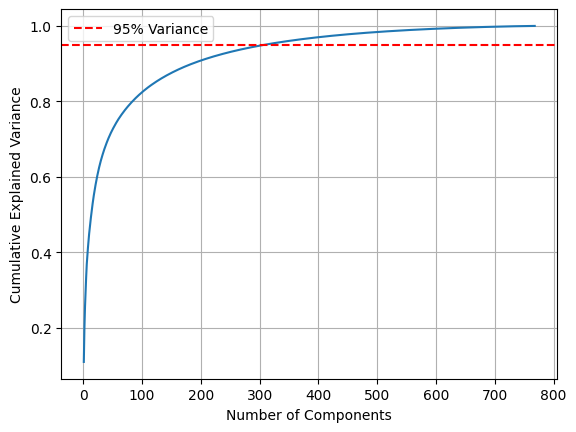

Optimal number of components: 309


In [9]:
from sklearn.decomposition import PCA

embeddings_matrix = np.vstack(df['cls_embedding'].values)

pca = PCA()
pca.fit(embeddings_matrix)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.legend()
plt.show()

optimal_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Optimal number of components: {optimal_components}")

In [10]:
pca = PCA(n_components = optimal_components)
reduced_embeddings = pca.fit_transform(embeddings_matrix)

df['reduced_embedding'] = list(reduced_embeddings)

In [1]:
import pandas as pd

In [12]:
df = pd.read_parquet('/Users/jiazhengli/Desktop/trials_pmid_papers_results.parquet')
df

,protocolSection.identificationModule.nctId,pmid_list,Abstract,is_cancer,results,protocolSection.descriptionModule.briefSummary,protocolSection.descriptionModule.detailedDescription,protocolSection.identificationModule.briefTitle,protocolSection.identificationModule.officialTitle
0,NCT05143775,[34599481],[Many patients with glioma experience surgery-...,True,[Not a Publication],This study is designed to compare the language...,This study concentrates on patient who has typ...,Strategic Intervention on Preserving Language ...,Strategic Intervention on Preserving Language ...
1,NCT02953301,[32632956],[Mycosis fungoides (MF) is the most common typ...,True,[Not a Publication],The purpose of this study is to determine whet...,None,Resminostat for Maintenance Treatment of Patie...,"A Multicentre, Double Blind, Randomised, Place..."
2,NCT05060471,"[28055103, 23484057, 8348857, 8874455, 2035453...","[Each year, the American Cancer Society estima...",True,"[Not a Publication, Not a Publication, Positiv...",Locally Advanced Anal Canal Squamous Carcinoma...,None,PD-1 Blockade Combined with Chemotherapy Follo...,Neoadjuvant PD-1 Blockade Combined with Chemot...
3,NCT03893903,[35599302],[Isocitrate dehydrogenase (IDH) mutations are ...,True,[Not a Publication],The trial will address safety and tolerability...,The standard of care (SOC) treatment of patien...,AMPLIFYing NEOepitope-specific VACcine Respons...,AMPLIFYing NEOepitope-specific VACcine Respons...
4,NCT04062045,"[28217054, 30233861, 27501016, 30532584, 29980...",[The main advantages of video assisted thoraco...,True,"[Unknown, Unknown, Not a Publication, Not a Pu...",Investigators will analyze the efficacy of con...,None,Efficacy of Continous Regional Anesthesia Usin...,Efficacy of Continous Regional Anesthesia Usin...
...,...,...,...,...,...,...,...,...,...
24905,NCT05248009,"[28096199, 20236380, 11316562, 30945803]",[Background: Although the number of cancer sur...,True,None,Consenting subjects will receive a semi-perman...,Over 3 million patients are treated each year ...,Feasibility of Semi-Permanent Tattoo for Treat...,Feasibility of Semi-Permanent Tattoo for Treat...
24906,NCT03310541,[35440569],[AKT- a key molecular regulator of PI-3K signa...,True,None,This study will test the recommended dose of A...,None,AZD5363 in Patients With Advanced Solid Tumors...,A Pilot Study of AZD5363 for Patients With Adv...
24907,NCT02009176,"[15508102, 18019727, 9409569, 15798459, 188368...",[Estimates from the year 2000 indicate that li...,True,None,The purpose of this study is to compare short-...,Background:Hepatocellular carcinoma is the wor...,Laparoscope Anatomical and Aon-anatomical Hepa...,"The Prospective, Randomized Case-control(RCT) ..."
24908,NCT02069093,"[32043762, 31594912, 28314691]",[The incidence of oral mucositis (any grade) a...,True,None,"Open-label, Phase II study of Stomatitis preve...",None,"Open-label, Phase II Study of Stomatitis Preve...","A Phase II, Single Arm Study of the Use of Ste..."


In [11]:
df_all = pd.read_parquet('/Users/jiazhengli/Desktop/project_root/clinical_trials_combined.parquet')
df_all

,hasResults,protocolSection.identificationModule.nctId,protocolSection.identificationModule.orgStudyIdInfo.id,protocolSection.identificationModule.organization.fullName,protocolSection.identificationModule.organization.class,protocolSection.identificationModule.briefTitle,protocolSection.identificationModule.officialTitle,protocolSection.statusModule.statusVerifiedDate,protocolSection.statusModule.overallStatus,protocolSection.statusModule.expandedAccessInfo.hasExpandedAccess,...,protocolSection.oversightModule.isUnapprovedDevice,protocolSection.statusModule.delayedPosting,resultsSection.moreInfoModule.pointOfContact.phoneExt,protocolSection.designModule.nPtrsToThisExpAccNctId,protocolSection.designModule.expandedAccessTypes.individual,protocolSection.oversightModule.fdaaa801Violation,annotationSection.annotationModule.violationAnnotation.violationEvents,protocolSection.designModule.expandedAccessTypes.intermediate,protocolSection.designModule.expandedAccessTypes.treatment,protocolSection.oversightModule.isPpsd
0,False,NCT05353218,2021/923,Istanbul University,OTHER,Ultrasound-Guided Intermediate Versus Deep Cer...,Efficacy of Ultrasound-Guided Intermediate Ver...,2023-04,COMPLETED,False,...,None,None,None,NaN,None,None,None,None,None,None
1,False,NCT05713162,PIC-04-17,Fundació Sant Joan de Déu,OTHER,Evaluation of the Effect of a Social Skills Pr...,Evaluation of the Effectiveness of a Social Sk...,2022-03,COMPLETED,False,...,None,None,None,NaN,None,None,None,None,None,None
2,False,NCT05143775,KY 2020-099-01,Beijing Neurosurgical Institute,OTHER,Strategic Intervention on Preserving Language ...,Strategic Intervention on Preserving Language ...,2021-12,UNKNOWN,False,...,None,None,None,NaN,None,None,None,None,None,None
3,False,NCT06041633,1072.6120.312.2021-15.12.2,Jagiellonian University,OTHER,Preliminary Assessment of the Psycho-emotional...,Preliminary Assessment of the Psycho-emotional...,2023-09,RECRUITING,False,...,None,None,None,NaN,None,None,None,None,None,None
4,False,NCT05988710,222204,Vanderbilt University Medical Center,OTHER,Low-dose Buccal Buprenorphine: Relative Abuse ...,Low-dose Buccal Buprenorphine: Relative Abuse ...,2024-12,RECRUITING,False,...,None,None,None,NaN,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521995,False,NCT04468438,Example 3,Assiut University,OTHER,Role of Estrogen in the Flarring up of Lupus N...,Role of Estrogen in the Flarring up of Lupus N...,2019-11,UNKNOWN,False,...,None,None,None,NaN,None,None,None,None,None,None
521996,False,NCT00254020,380-2004,Sunnybrook Health Sciences Centre,OTHER,The Role of Cytokine-Serotonin Interactions in...,The Role of Cytokine-Serotonin Interactions in...,2017-04,COMPLETED,False,...,None,None,None,NaN,None,None,None,None,None,None
521997,False,NCT05298072,22-10590-BO,"University Hospital, Essen",OTHER,Identification of Novel Inflammation-related B...,Identification of Novel Inflammation-related B...,2022-03,UNKNOWN,False,...,None,None,None,NaN,None,None,None,None,None,None
521998,False,NCT04474067,DM002,Hadassah Medical Organization,OTHER,COVID-19 - Cytokine Storm,A Multi-Center Study Evaluating Clinical Cours...,2020-12,UNKNOWN,False,...,None,None,None,NaN,None,None,None,None,None,None


In [14]:
# df_all.columns[:50]
df_all['protocolSection.designModule.studyType']

0         INTERVENTIONAL
1         INTERVENTIONAL
2         INTERVENTIONAL
3          OBSERVATIONAL
4         INTERVENTIONAL
               ...      
521995     OBSERVATIONAL
521996    INTERVENTIONAL
521997     OBSERVATIONAL
521998     OBSERVATIONAL
521999    INTERVENTIONAL
Name: protocolSection.designModule.studyType, Length: 522000, dtype: object

In [27]:
# # Make sure the column names are stripped of leading/trailing spaces
# df.columns = df.columns.str.strip()
# df_all.columns = df_all.columns.str.strip()

# # Perform the merge based on NCT ID
# df_merged = pd.merge(
#     df,
#     df_all[
#         [
#             'protocolSection.identificationModule.nctId',
#             'protocolSection.descriptionModule.briefSummary',
#             'protocolSection.descriptionModule.detailedDescription',
#             'protocolSection.identificationModule.briefTitle','protocolSection.identificationModule.officialTitle'
#         ]
#     ],
#     on='protocolSection.identificationModule.nctId',
#     how='left'
# )
# Make sure the column names are stripped of leading/trailing spaces
df.columns = df.columns.str.strip()
df_all.columns = df_all.columns.str.strip()

# Perform the merge based on NCT ID
df_merged = pd.merge(
    df,
    df_all[['protocolSection.identificationModule.nctId', 'protocolSection.armsInterventionsModule.interventions']],
    on='protocolSection.identificationModule.nctId',
    how='left'
)

In [28]:
df_merged

,protocolSection.identificationModule.nctId,pmid_list,Abstract,is_cancer,results,protocolSection.descriptionModule.briefSummary,protocolSection.descriptionModule.detailedDescription,protocolSection.identificationModule.briefTitle,protocolSection.identificationModule.officialTitle,protocolSection.armsInterventionsModule.interventions
0,NCT05143775,[34599481],[Many patients with glioma experience surgery-...,True,[Not a Publication],This study is designed to compare the language...,This study concentrates on patient who has typ...,Strategic Intervention on Preserving Language ...,Strategic Intervention on Preserving Language ...,[{'armGroupLabels': ['new surgical plan group'...
1,NCT02953301,[32632956],[Mycosis fungoides (MF) is the most common typ...,True,[Not a Publication],The purpose of this study is to determine whet...,None,Resminostat for Maintenance Treatment of Patie...,"A Multicentre, Double Blind, Randomised, Place...","[{'armGroupLabels': ['resminostat'], 'descript..."
2,NCT05060471,"[28055103, 23484057, 8348857, 8874455, 2035453...","[Each year, the American Cancer Society estima...",True,"[Not a Publication, Not a Publication, Positiv...",Locally Advanced Anal Canal Squamous Carcinoma...,None,PD-1 Blockade Combined with Chemotherapy Follo...,Neoadjuvant PD-1 Blockade Combined with Chemot...,"[{'armGroupLabels': ['Intervetional group'], '..."
3,NCT03893903,[35599302],[Isocitrate dehydrogenase (IDH) mutations are ...,True,[Not a Publication],The trial will address safety and tolerability...,The standard of care (SOC) treatment of patien...,AMPLIFYing NEOepitope-specific VACcine Respons...,AMPLIFYing NEOepitope-specific VACcine Respons...,"[{'armGroupLabels': ['IDH1 peptide vaccine', '..."
4,NCT04062045,"[28217054, 30233861, 27501016, 30532584, 29980...",[The main advantages of video assisted thoraco...,True,"[Unknown, Unknown, Not a Publication, Not a Pu...",Investigators will analyze the efficacy of con...,None,Efficacy of Continous Regional Anesthesia Usin...,Efficacy of Continous Regional Anesthesia Usin...,[{'armGroupLabels': ['Group A - Local anesthet...
...,...,...,...,...,...,...,...,...,...,...
24905,NCT05248009,"[28096199, 20236380, 11316562, 30945803]",[Background: Although the number of cancer sur...,True,None,Consenting subjects will receive a semi-perman...,Over 3 million patients are treated each year ...,Feasibility of Semi-Permanent Tattoo for Treat...,Feasibility of Semi-Permanent Tattoo for Treat...,[{'armGroupLabels': ['Semi-Permanent Tattoo In...
24906,NCT03310541,[35440569],[AKT- a key molecular regulator of PI-3K signa...,True,None,This study will test the recommended dose of A...,None,AZD5363 in Patients With Advanced Solid Tumors...,A Pilot Study of AZD5363 for Patients With Adv...,"[{'armGroupLabels': ['Advanced Solid Tumors', ..."
24907,NCT02009176,"[15508102, 18019727, 9409569, 15798459, 188368...",[Estimates from the year 2000 indicate that li...,True,None,The purpose of this study is to compare short-...,Background:Hepatocellular carcinoma is the wor...,Laparoscope Anatomical and Aon-anatomical Hepa...,"The Prospective, Randomized Case-control(RCT) ...",[{'armGroupLabels': ['Laparoscop Anatomical He...
24908,NCT02069093,"[32043762, 31594912, 28314691]",[The incidence of oral mucositis (any grade) a...,True,None,"Open-label, Phase II study of Stomatitis preve...",None,"Open-label, Phase II Study of Stomatitis Preve...","A Phase II, Single Arm Study of the Use of Ste...",[{'armGroupLabels': ['Dexamethasone based mout...


In [7]:
df_merged['protocolSection.descriptionModule.briefSummary'].isna().sum()

np.int64(0)

In [8]:
df_merged['protocolSection.descriptionModule.detailedDescription'].isna().sum()

np.int64(6421)

In [33]:
import numpy as np

df_merged['intervention_types'] = df_merged['protocolSection.armsInterventionsModule.interventions'].apply(
    lambda x: [d.get('type') for d in x] if isinstance(x, (list, np.ndarray)) else None
)

In [43]:
from collections import Counter
import pandas as pd

# Step 1: Drop nulls and convert each row to a set (to remove duplicates within a trial)
unique_types_per_trial = df_merged['intervention_types'].dropna().apply(lambda x: set(x))

# Step 2: Flatten the sets and count each unique type across all trials
flat_types = [t for types in unique_types_per_trial for t in types]
type_counts = Counter(flat_types)

# Step 3: Convert to DataFrame for display
type_counts_df = pd.DataFrame.from_dict(type_counts, orient='index', columns=['count']).reset_index()
type_counts_df.columns = ['intervention_type', 'count']


In [44]:
type_counts_df

,intervention_type,count
0,PROCEDURE,3594
1,DRUG,15586
2,RADIATION,2183
3,BIOLOGICAL,2814
4,DEVICE,1552
5,COMBINATION_PRODUCT,138
6,OTHER,3306
7,DIETARY_SUPPLEMENT,413
8,BEHAVIORAL,1648
9,DIAGNOSTIC_TEST,381


In [54]:
df_merged.to_parquet('/Users/jiazhengli/Desktop/trials_pmid_papers_results.parquet')